# check oof df

In [24]:
import os

import numpy as np
import pandas as pd
from pandarallel import pandarallel
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

# post process fn

In [28]:
import sys
sys.path.append("/kaggle/src/dss_utils")
from dss_metrics import score


In [21]:
# postprocess_fn
# series_idでgroupbyして、class_predに対して対象の列のデータから前のN個の列までのデータの平均をとる
import torch
import torch.nn as nn

# 1step 0.5secで30minなら60*30=1800step
def postprocess_fn(df, N=1800, maxpool_kernel_size=101, maxpool_stride=1):
    df = df.copy()
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]

    # 入力サイズと出力サイズが一致するようにpaddingを調整
    maxpool_padding = int((maxpool_kernel_size - maxpool_stride) / 2)
    # maxpoolしてピーク検出
    max_pooling = nn.MaxPool1d(maxpool_kernel_size, stride=maxpool_stride, padding=maxpool_padding)
    event_pred = df["event_pred"].values
    event_pred = torch.tensor(event_pred).unsqueeze(0)
    pooled_event_pred = max_pooling(np.abs(event_pred)).squeeze(0).numpy()
    event_pred = event_pred.squeeze(0).numpy()
    # peakのところだけ残すmaskを作成
    peak_event_pred_mask = np.where(pooled_event_pred == np.abs(event_pred), 1, 0)
    peak_event_pred = event_pred * peak_event_pred_mask
    df["event_pred"] = peak_event_pred
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df


def make_submission_df(df, threshold=0.1):
    df = df[["series_id", "step", "event_pred"]].copy()
    # thresholdより大きいときは1,-thresholdより小さいときは-1,それ以外は0
    df["event"] = df["event_pred"].apply(lambda x: 1 if x > threshold else -1 if x < -threshold else 0)
    df = df[df["event"] != 0].copy()
    df["event"] = df["event"].replace({1: "wakeup", -1: "onset"})
    df["score"] = df["event_pred"].apply(lambda x: np.clip(np.abs(x), 0.0, 1.0))
    return df

In [3]:
output_dir = os.path.join("/kaggle", "working")
# exp_name = "debug"
exp_name = "baseline_alldata_000"
oof_df_path = os.path.join(output_dir, exp_name,"oof_df.parquet")
oof_df = pd.read_parquet(oof_df_path)

In [4]:
oof_df.columns

Index(['series_id', 'step', 'timestamp', 'anglez', 'enmo', 'anglez_absdiff',
       'enmo_absdiff', 'anglez_absdiff_ave', 'enmo_absdiff_ave', 'event',
       'event_onset', 'event_wakeup', 'date', 'series_date_key',
       'series_date_key_str', 'class_pred', 'class_target', 'event_pred'],
      dtype='object')

In [5]:
oof_df.head()

,series_id,step,timestamp,anglez,enmo,anglez_absdiff,enmo_absdiff,anglez_absdiff_ave,enmo_absdiff_ave,event,event_onset,event_wakeup,date,series_date_key,series_date_key_str,class_pred,class_target,event_pred
6644251,0ec9fc461819,0,2019-03-27T14:00:00-0400,-11.080400,0.0335,0.000000,0.0000,0.0,0.0,0.0,0,0,2019-03-27,400,0ec9fc461819_2019-03-27,0.028885,0.0,0.0
6644252,0ec9fc461819,1,2019-03-27T14:00:05-0400,-16.320299,0.0562,5.239899,0.0227,0.0,0.0,0.0,0,0,2019-03-27,400,0ec9fc461819_2019-03-27,0.031174,0.0,0.0
6644253,0ec9fc461819,2,2019-03-27T14:00:10-0400,-18.830999,0.0441,2.510700,0.0121,0.0,0.0,0.0,0,0,2019-03-27,400,0ec9fc461819_2019-03-27,0.033386,0.0,0.0
6644254,0ec9fc461819,3,2019-03-27T14:00:15-0400,-18.533800,0.0408,0.297199,0.0033,0.0,0.0,0.0,0,0,2019-03-27,400,0ec9fc461819_2019-03-27,0.035461,0.0,0.0
6644255,0ec9fc461819,4,2019-03-27T14:00:20-0400,-11.525700,0.0520,7.008101,0.0112,0.0,0.0,0.0,0,0,2019-03-27,400,0ec9fc461819_2019-03-27,0.037354,0.0,0.0


In [6]:
# oof_df = oof_df[oof_df["series_date_key"]=="1087d7b0ff2e_2018-03-13"]
# print(len(oof_df))

In [17]:
def plot_inputs(df):
    plt.figure(figsize=(12, 5))
    plt.suptitle("inputs")
    plt.subplot(4, 1, 1)
    plt.plot(df["step"], df["anglez"])
    plt.xticks([])
    plt.subplot(4, 1, 2)
    plt.plot(df["step"], df["enmo"])
    plt.tight_layout()
    plt.xticks([])
    plt.subplot(4, 1, 3)
    plt.plot(df["step"], df["anglez_absdiff_ave"])
    plt.tight_layout()
    plt.xticks([])
    plt.subplot(4, 1, 4)
    plt.plot(df["step"], df["enmo_absdiff_ave"])
    plt.tight_layout()
    plt.show()

In [8]:
def plot_event_onset(df):
    plt.figure(figsize=(10, 5))
    plt.suptitle("event_onset")
    plt.subplot(3, 1, 1)
    plt.plot(df["step"], df["event_onset"], label="label")
    plt.xticks([])
    plt.subplot(3, 1, 2)
    plt.plot(df["step"], df["event_onset_target"], label="pred")
    plt.xticks([])
    plt.subplot(3, 1, 3)
    plt.plot(df["step"], df["event_onset_pred"], label="pred")
    plt.tight_layout()
    plt.show()

In [9]:
def plot_event_wakeup(df):
    plt.figure(figsize=(10, 5))
    plt.suptitle("event_wakeup")
    plt.subplot(3, 1, 1)
    plt.plot(df["step"], df["event_wakeup"], label="label")
    plt.xticks([])
    plt.subplot(3, 1, 2)
    plt.plot(df["step"], df["event_wakeup_target"], label="pred")
    plt.xticks([])
    plt.subplot(3, 1, 3)
    plt.plot(df["step"], df["event_wakeup_pred"], label="pred")
    plt.tight_layout()
    plt.show()

In [18]:
def plot_event_sleep(df):
    plt.figure(figsize=(12, 5))
    plt.suptitle("class")
    plt.subplot(2, 1, 1)
    plt.plot(df["step"], df["class_target"], label="label")
    plt.xticks([])
    plt.subplot(2, 1, 2)
    plt.plot(df["step"], df["class_pred"], label="pred")
    plt.tight_layout()
    plt.show()

In [19]:
oof_df["series_date_key"].unique()

array([ 400,  401,  402, ..., 7627, 7628, 7629], dtype=int16)

# data check

[4729 7143 4236 4182 4376 1044 7162 5183 6157 4336]
4729


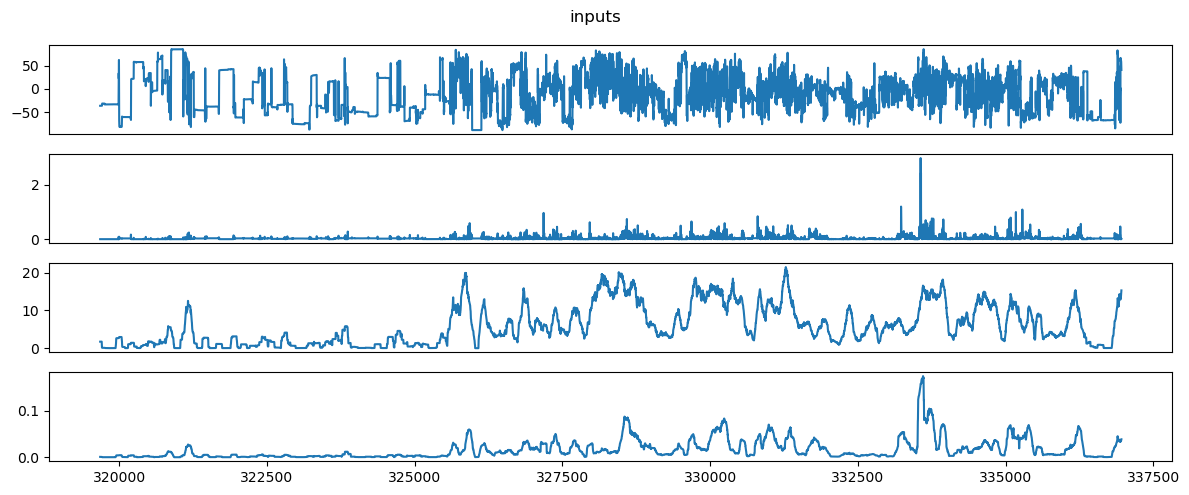

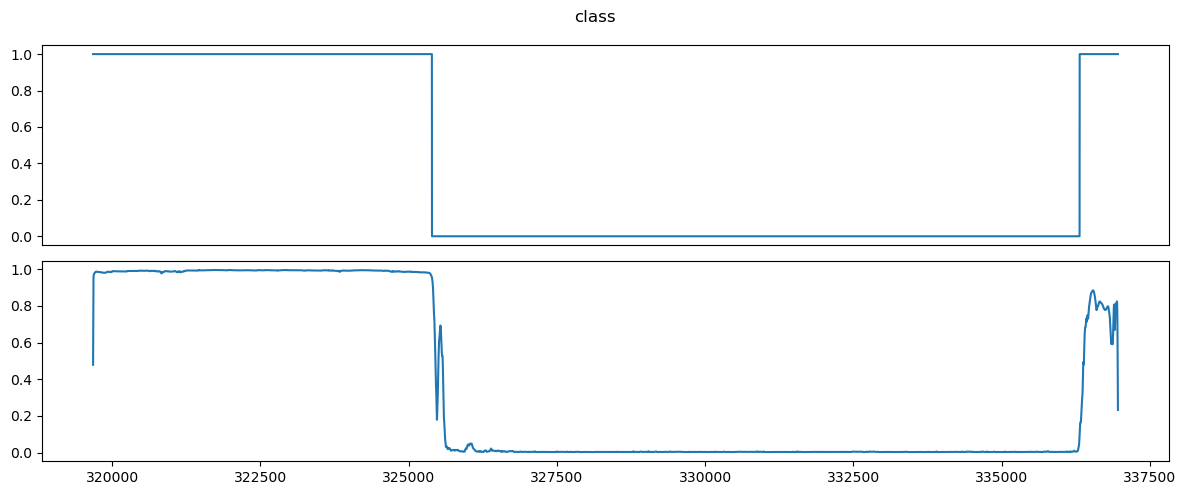

----------------------------------
7143


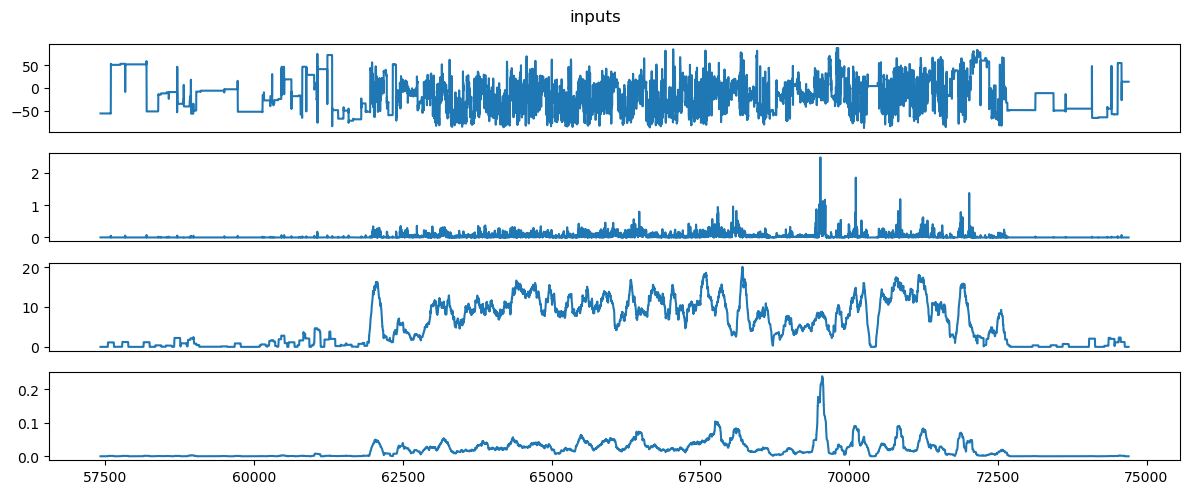

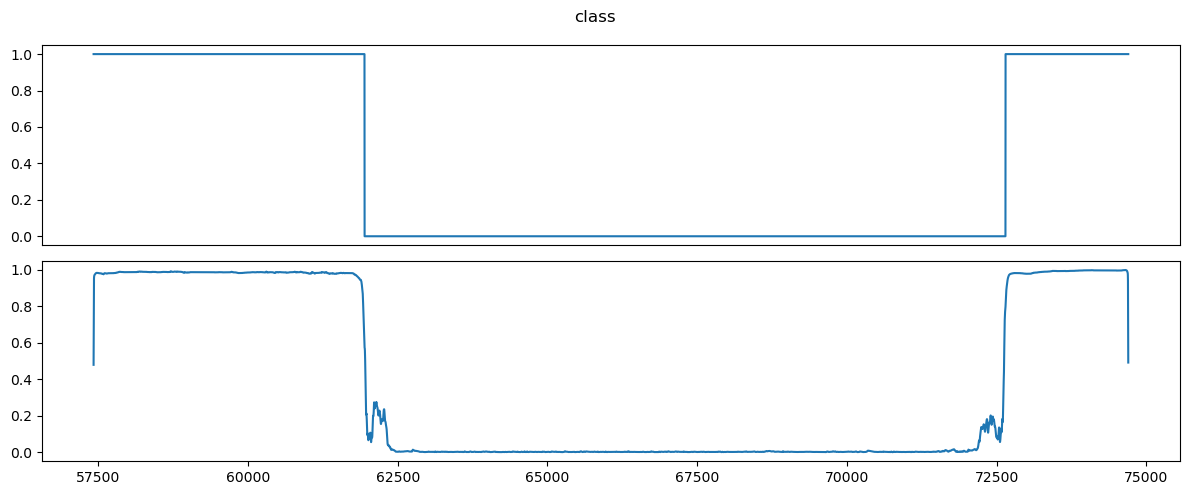

----------------------------------
4236


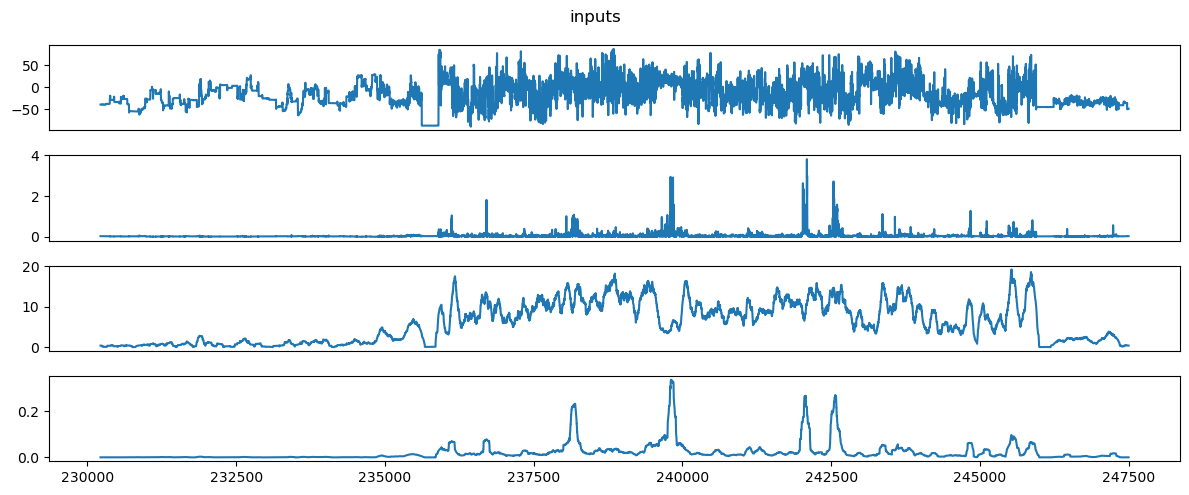

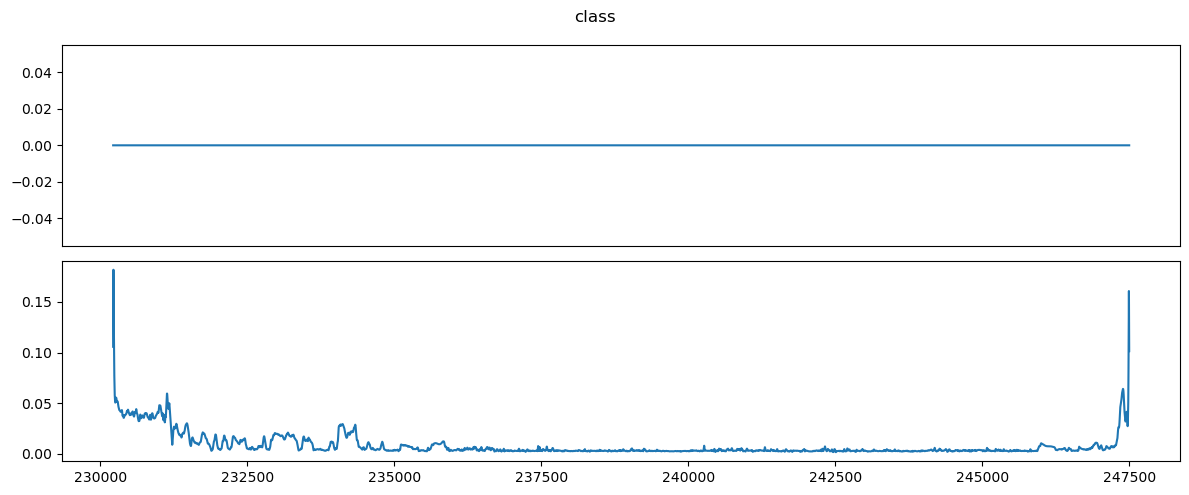

----------------------------------
4182


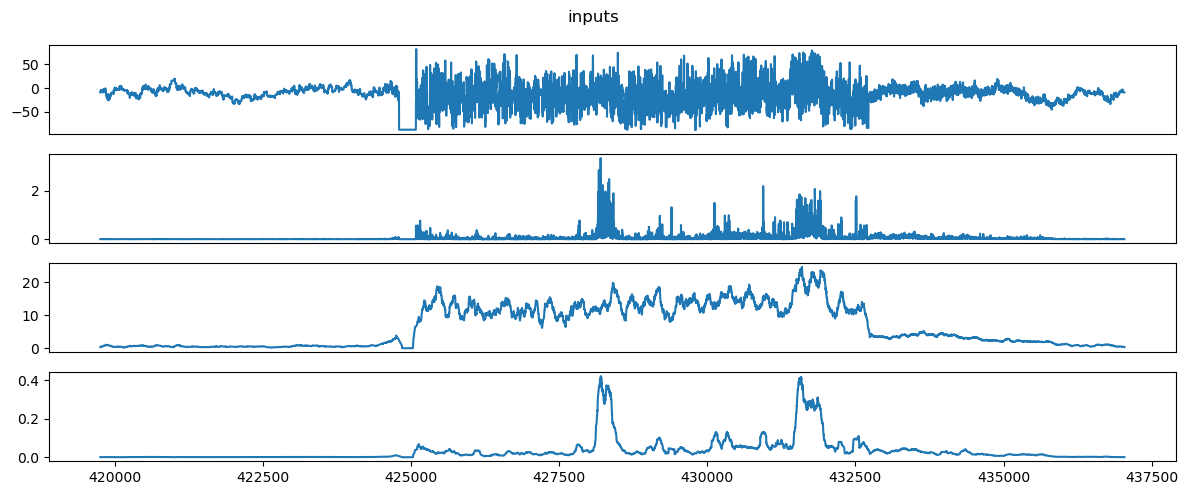

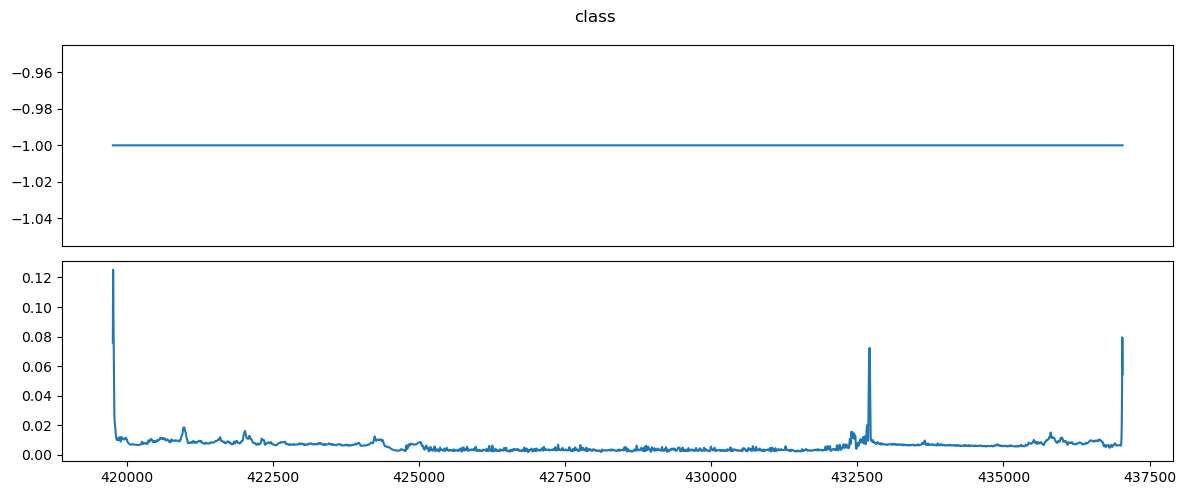

----------------------------------
4376


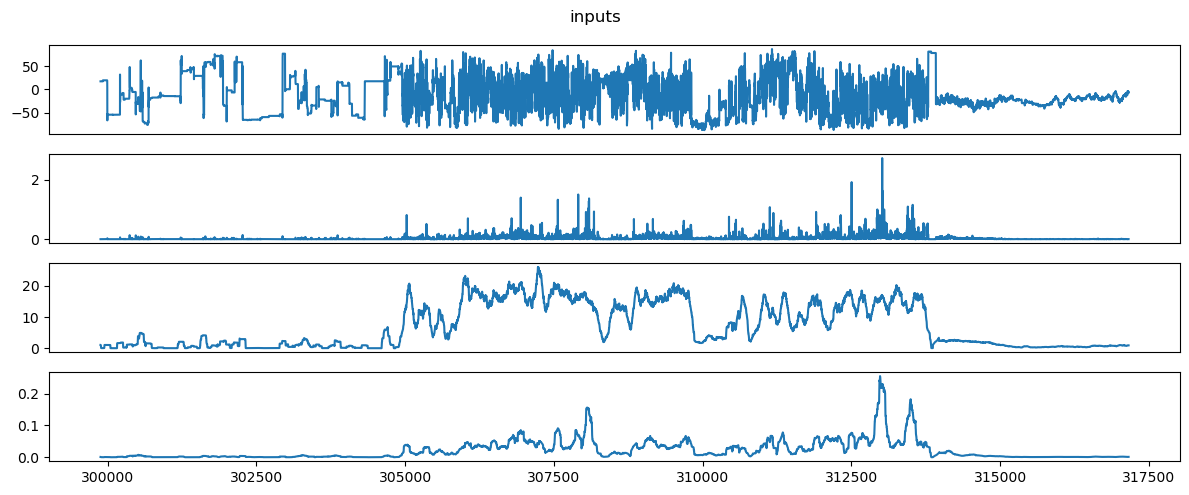

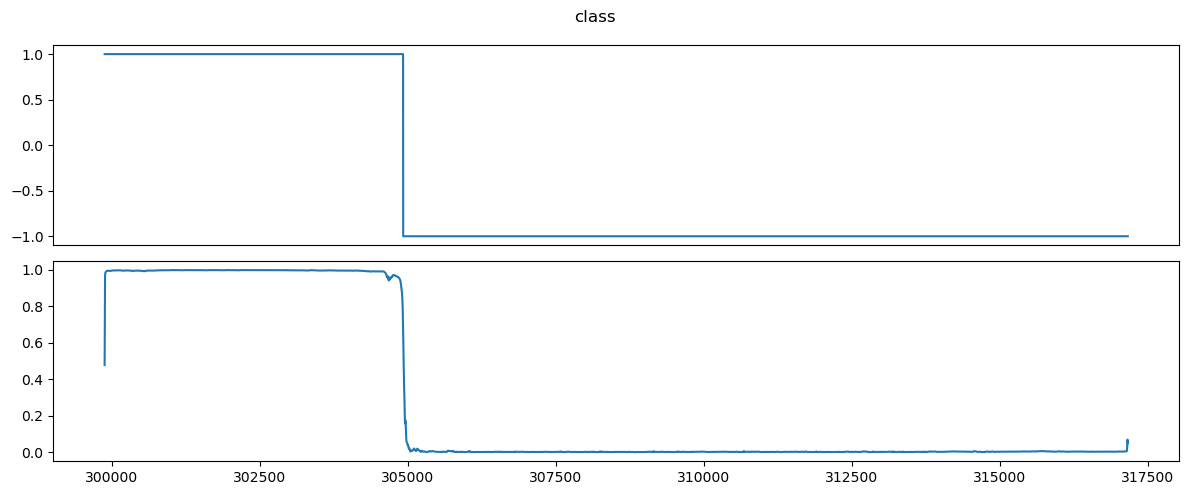

----------------------------------
1044


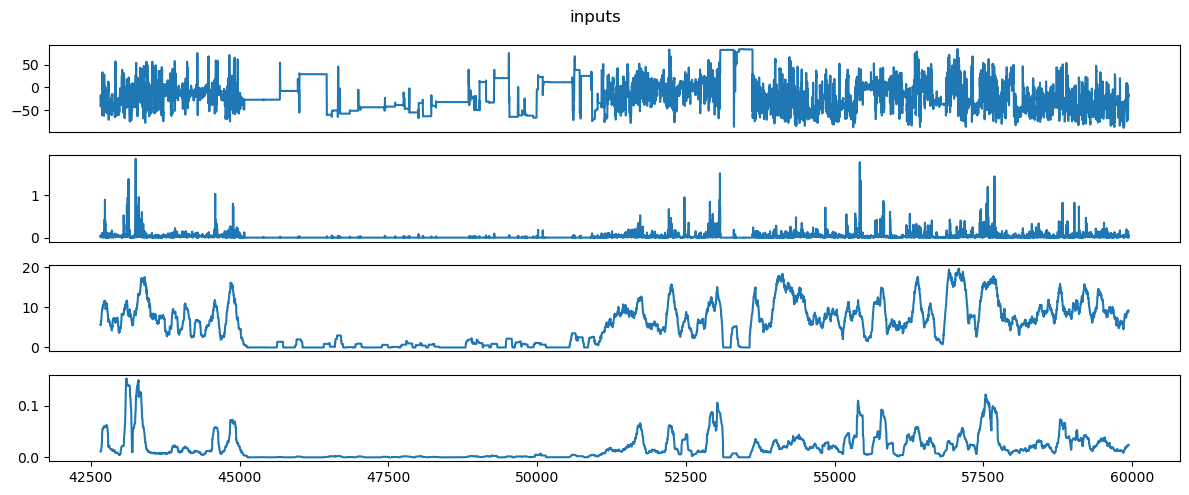

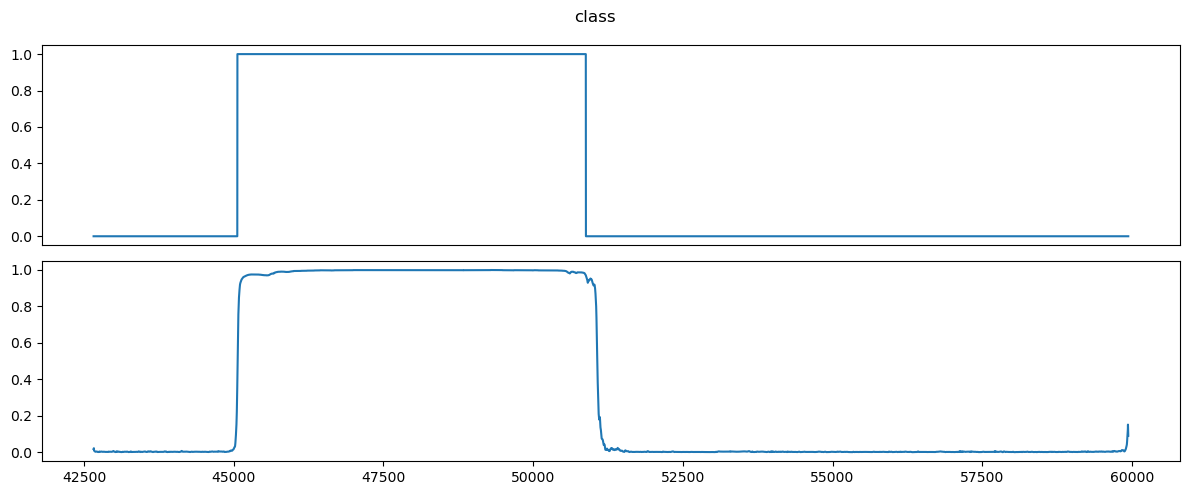

----------------------------------
7162


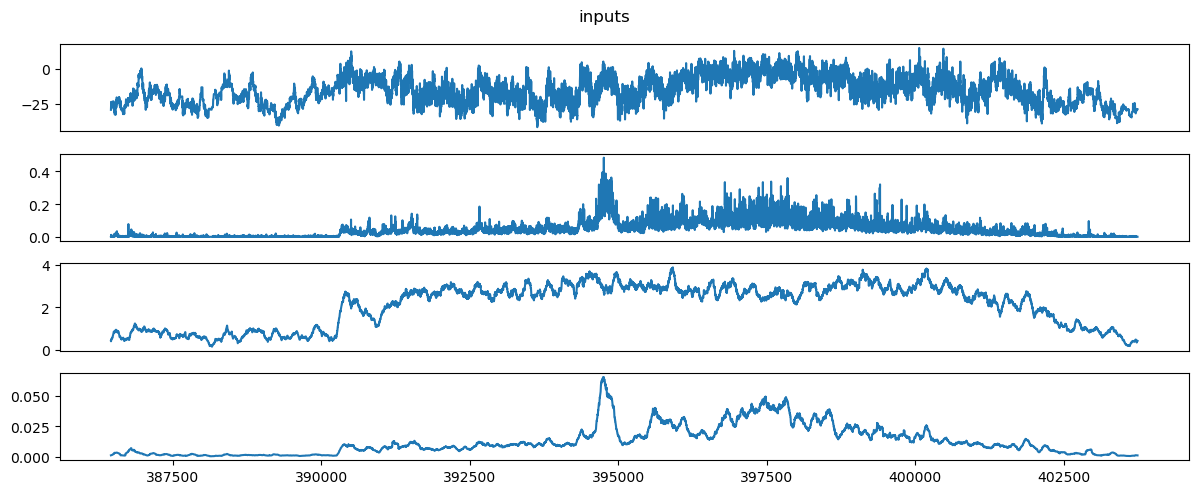

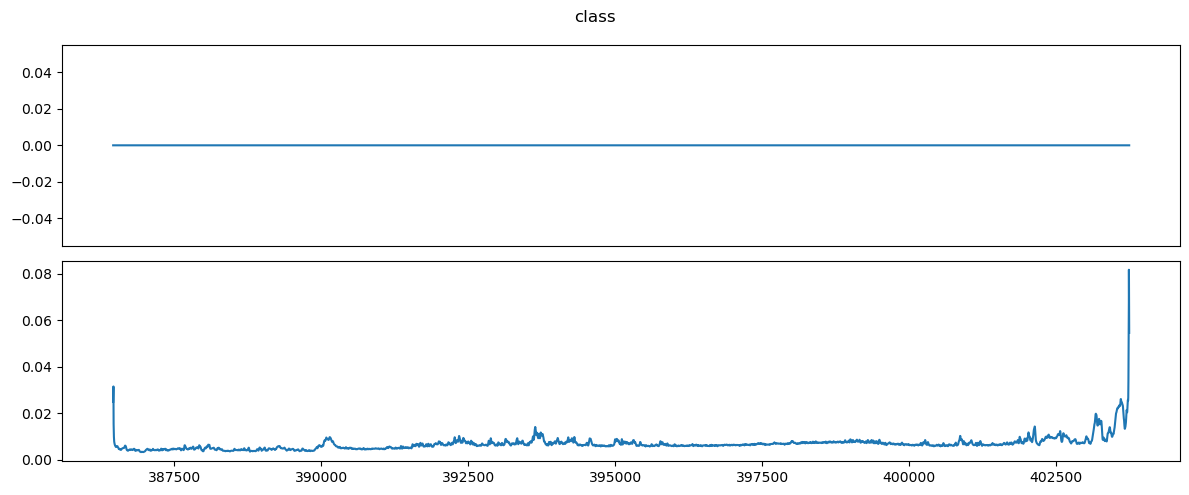

----------------------------------
5183


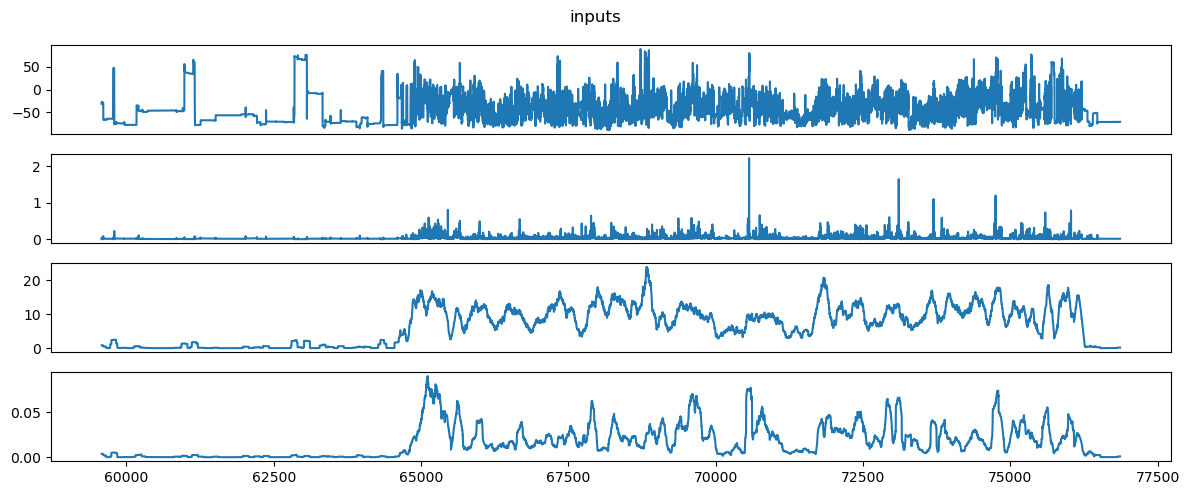

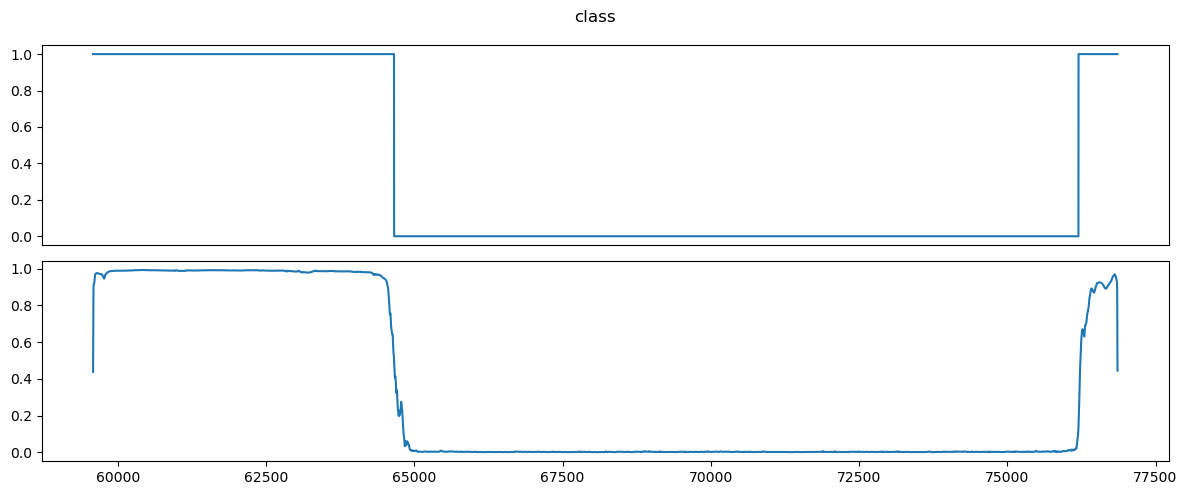

----------------------------------
6157


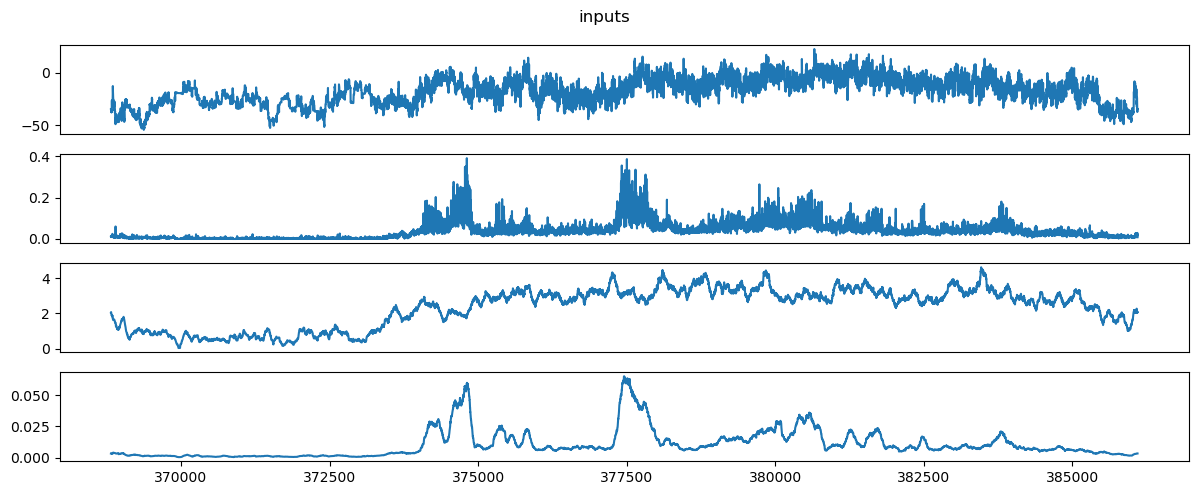

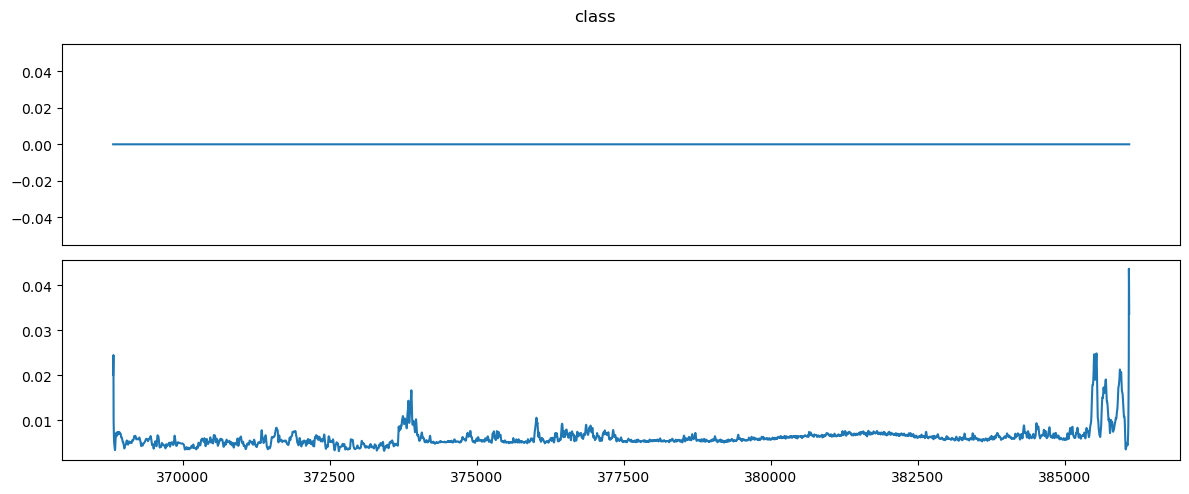

----------------------------------
4336


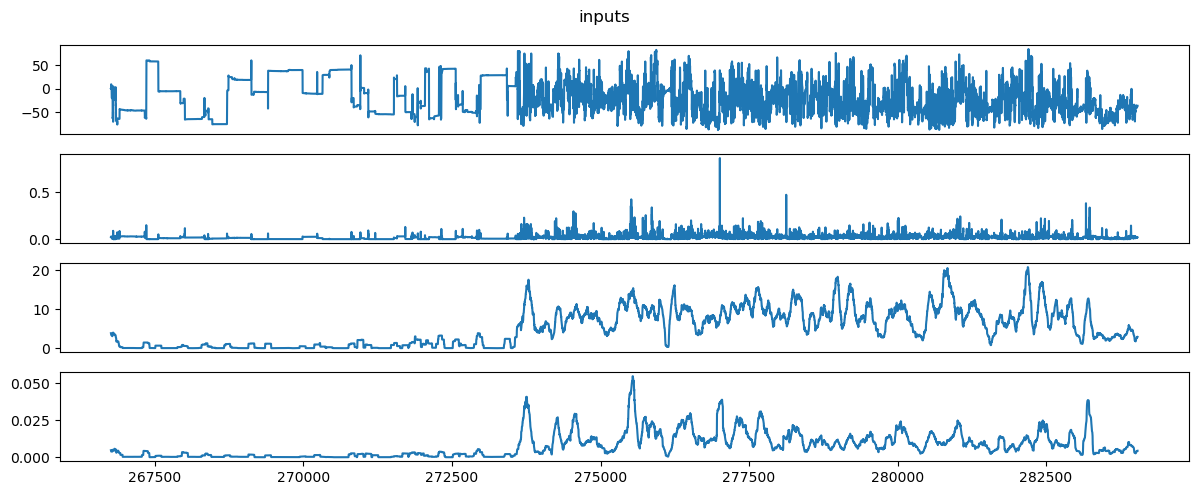

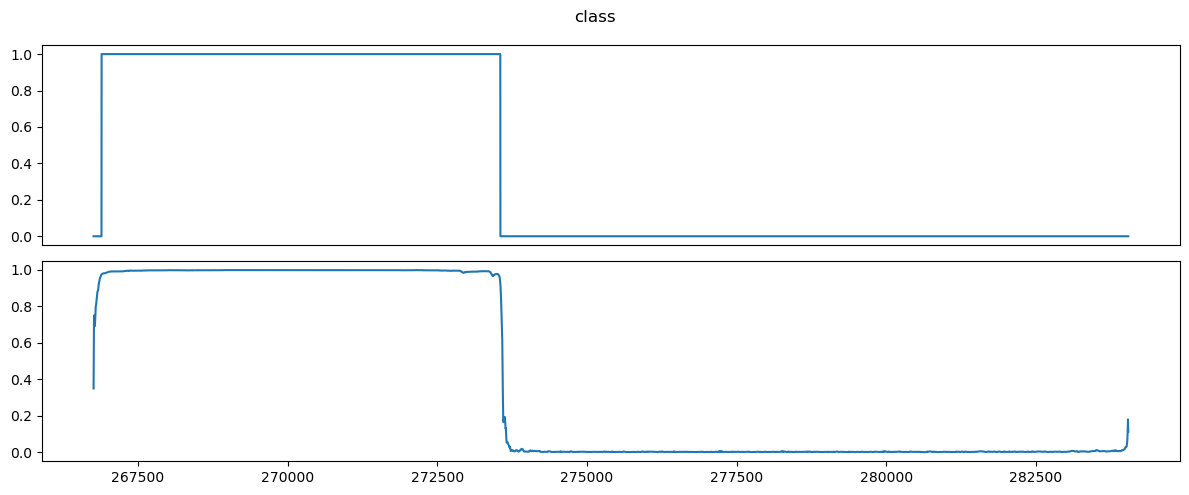

----------------------------------


In [22]:
random_series_date_key = np.random.choice(oof_df["series_date_key"].unique(), 10, replace=False)
print(random_series_date_key)
for key in random_series_date_key:
    print(key)
    df = oof_df[oof_df["series_date_key"]==key]
    plot_inputs(df)
    plot_event_sleep(df)
    # plot_event_onset(df)
    # plot_event_wakeup(df)
    print("----------------------------------")


# score check

In [23]:
df = postprocess_fn(oof_df, N=1200)
sub_df = make_submission_df(df, threshold=0.2)

/tmp/ipykernel_884/3531244271.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
/tmp/ipykernel_884/3531244271.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df["class_p

11182614
20998429
9916756
22776086
16527113


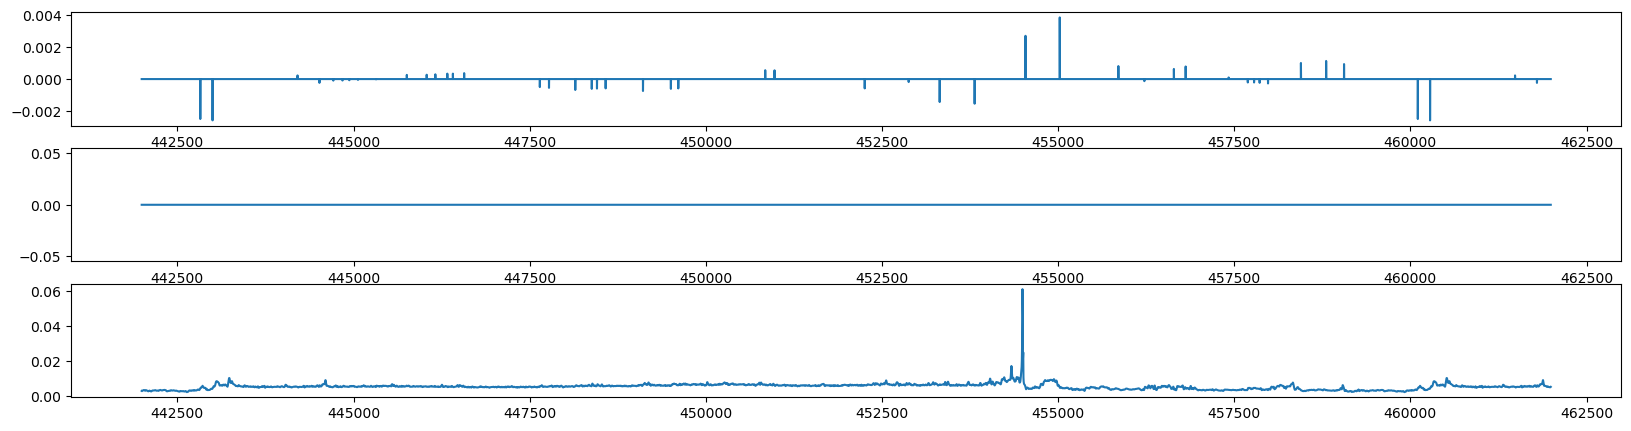

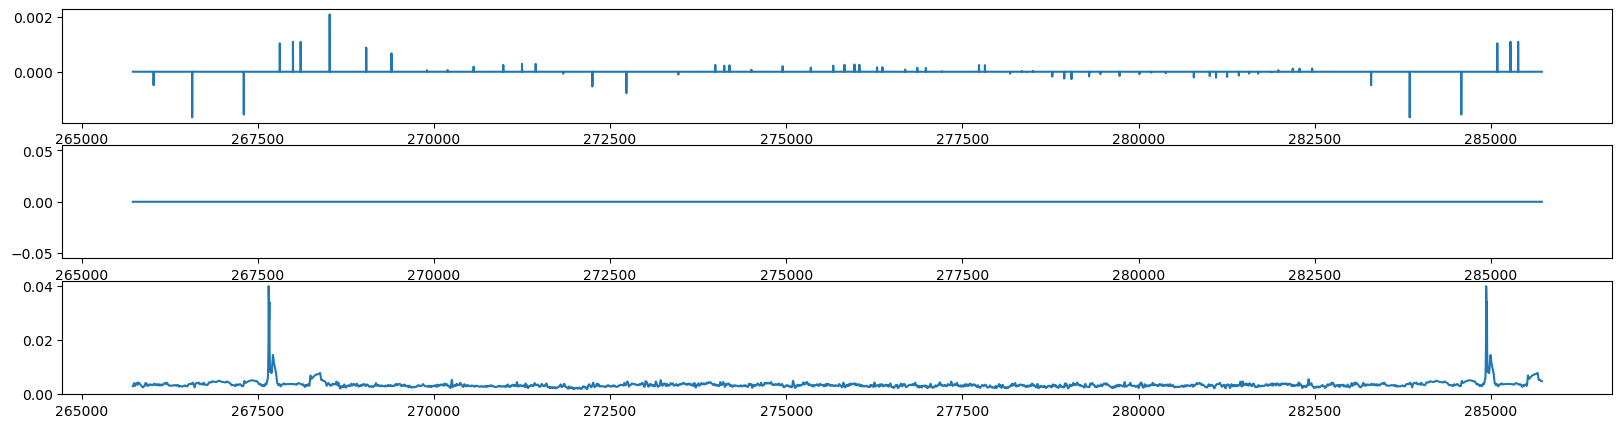

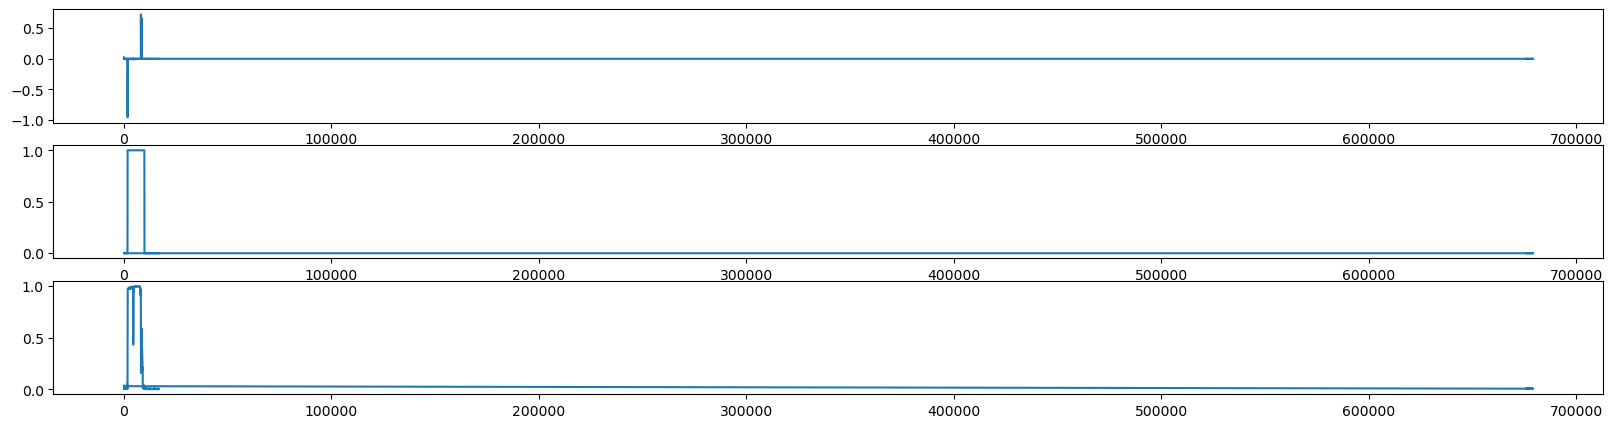

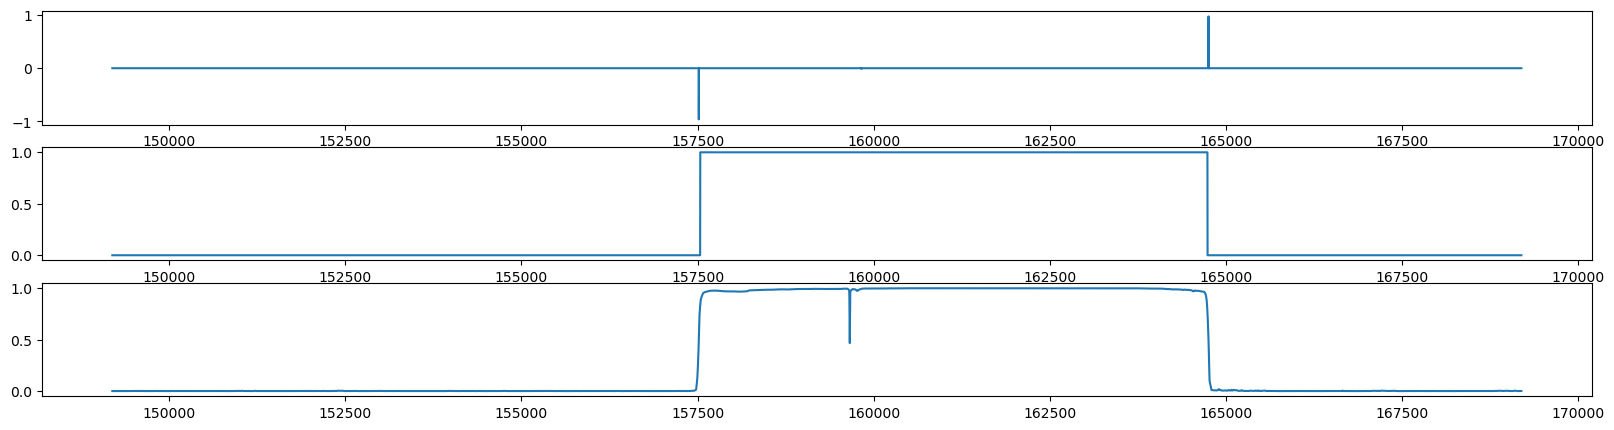

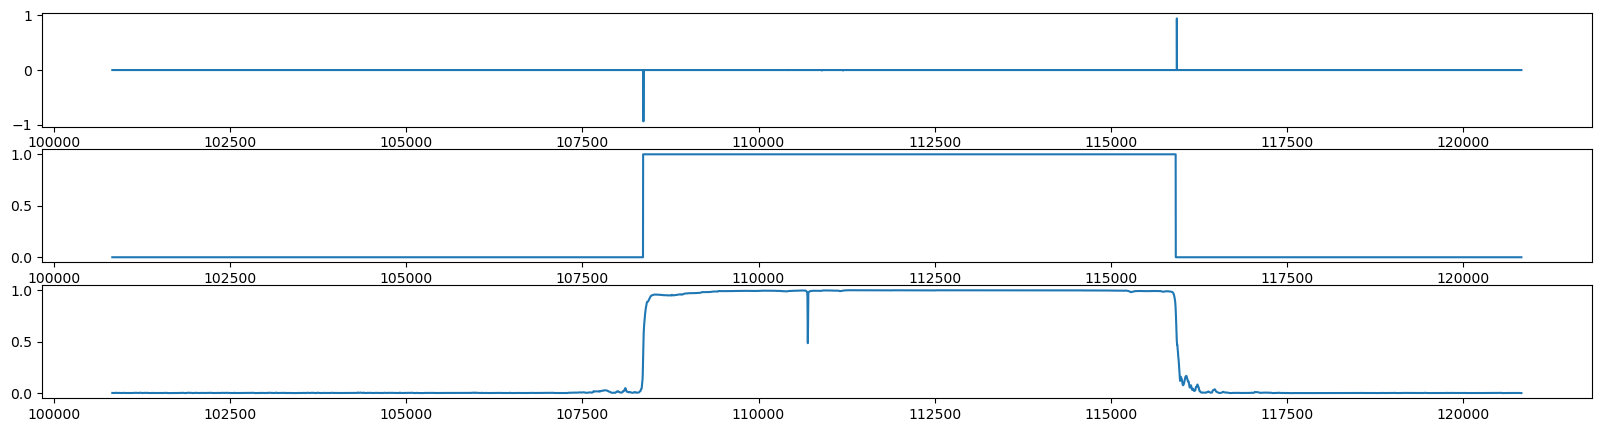

In [26]:
data_num = 20000
for _ in range(5):
    random_num = np.random.randint(0, len(df)-data_num)
    print(random_num)
    plt.figure(figsize=(20, 5))
    plt.subplot(3, 1, 1)
    plt.plot(df["step"].iloc[random_num:random_num+data_num], df["event_pred"].iloc[random_num:random_num+data_num], label="class_pred")
    plt.subplot(3, 1, 2)
    plt.plot(df["step"].iloc[random_num:random_num+data_num], df["event"].iloc[random_num:random_num+data_num], label="event_pred")
    plt.subplot(3, 1, 3)
    plt.plot(df["step"].iloc[random_num:random_num+data_num], df["class_pred"].iloc[random_num:random_num+data_num], label="class_pred")

In [27]:
train_event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
train_event_df = train_event_df[train_event_df["series_id"].isin(df["series_id"].unique())].copy()
train_event_df = train_event_df.reset_index(drop=True)
display(train_event_df.head())

,series_id,night,event,step,timestamp
0,0ec9fc461819,1,onset,6108.0,2019-03-27T22:29:00-0400
1,0ec9fc461819,1,wakeup,12060.0,2019-03-28T06:45:00-0400
2,0ec9fc461819,2,onset,26412.0,2019-03-29T02:41:00-0400
3,0ec9fc461819,2,wakeup,29424.0,2019-03-29T06:52:00-0400
4,0ec9fc461819,3,onset,41412.0,2019-03-29T23:31:00-0400


In [30]:
train_event_df.isnull().sum()

series_id       0
night           0
event           0
step         1226
timestamp    1226
dtype: int64

In [34]:
train_event_df_nonnull = train_event_df[train_event_df["step"].notnull()].copy()

In [35]:
train_event_df_nonnull.isnull().sum()

series_id    0
night        0
event        0
step         0
timestamp    0
dtype: int64

In [32]:
score(train_event_df, sub_df)

0.3827017787418735

In [36]:
score(train_event_df_nonnull, sub_df)

0.6657109187591811